## Предсказание уровней воды на реке Амур

Основной код взяд из бэзлайн решения, где вносились дополнения помечал комментарии !!!.
Финальная ячейка с обучением немного дополнительно расписалась мной

In [740]:
import gc

gc.collect()

14568

In [741]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap

from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV
from fbprophet import Prophet

In [742]:
# Путь до папки с данными
path_to_data = 'datasets/datasets/'

Определяем период, на который будем предсказывать (в нашем случае это первые 10 дней ноября 2019 года)

In [743]:
predict_period = ['2019-11-01', '2019-11-11'] 
f_day = datetime.strptime(predict_period[0], '%Y-%m-%d') 
l_day = datetime.strptime(predict_period[1], '%Y-%m-%d')
predict_ndays = (l_day - f_day).days

 Загрузка данных об уровнях воды на гидропостах.
 
 Датасет `daily.pkl` - собран из всех файлов `{номер_станции}_daily.csv` из папки 'datasets/', 
 номер гидропоста записан в отдельной колонке. Колонки приведены к соответствующим форматам, датасет отсортирован по (номеру гидропоста, дате)

In [744]:
daily = pd.read_pickle(path_to_data + 'processed_data/daily.pkl')

In [745]:
daily = daily.sort_values(by=['station_id','date'])
daily = daily.reset_index(drop=True)

In [746]:
# Выбираем целевые гидрологические посты
station_ids = [6005, 6022, 6027, 5004, 5012, 5024, 5805]
daily = daily[daily['station_id'].isin(station_ids)]

Посмотрим как выглядит ряд для фиксированного `station_id`

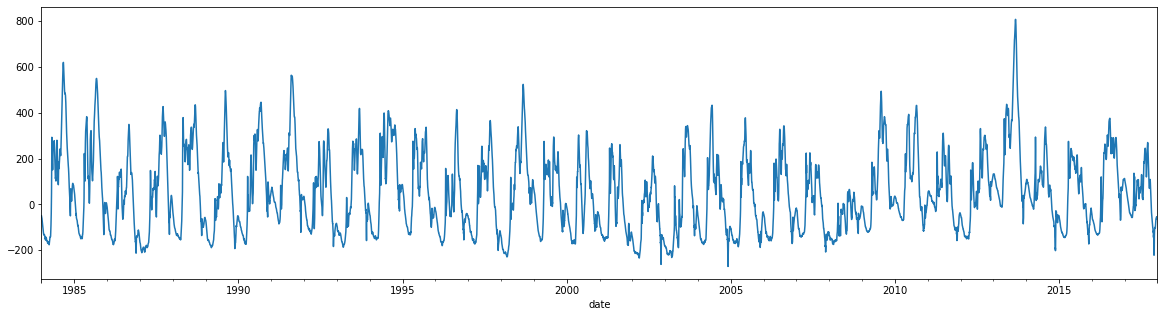

In [747]:
daily = daily.set_index('date')
daily.loc[daily['station_id'] == 5012, 'stage_max'].plot(figsize=(20, 5))
daily = daily.reset_index()

Загрузим и приведем к соответствующим форматам свежие данные по целевым вышкам, которые находятся в файле `datasets/hydro2019-20/new_data.csv`

In [748]:
nf = pd.read_csv(path_to_data + 'hydro_2018-2020/new_data_target.csv', sep=';')

In [749]:
nf['time'] = pd.to_datetime(nf['time'], format='%Y-%m-%d %H:%M:%S')
nf.columns = ['date', 'stage_max', 'station_id']
nf = nf.sort_values(by=['station_id', 'date'])
nf = nf.set_index('date')
nf = nf[nf.index > '2017-12-31']

Посмотрим на графики новых данных:

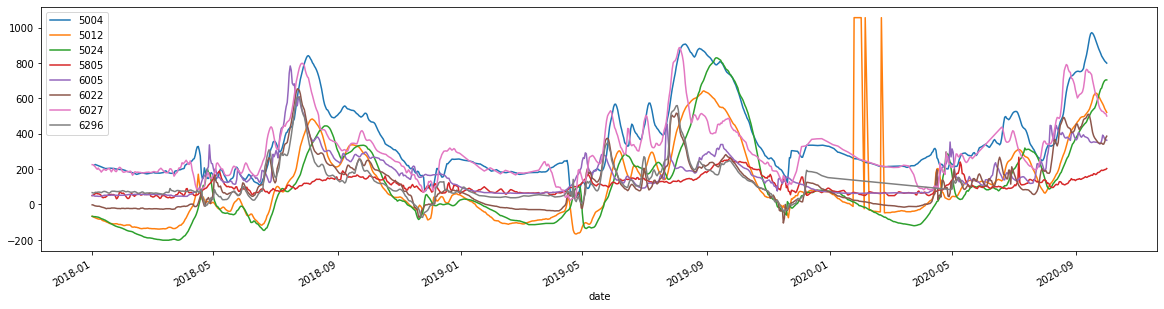

In [750]:
plt.figure(figsize=(20,5))
leg = []
for st in nf.station_id.unique():
    sf = nf[nf['station_id'] == st]
    sf['stage_max'].plot()
    leg.append(st)
plt.legend(leg)

Удалим выбросы у гидрологичского поста с номером 5012

In [751]:
nf.loc[(nf['stage_max'] > nf['stage_max'].\
          quantile(0.99))&(nf['station_id'] == 5012), 'stage_max'] = np.nan

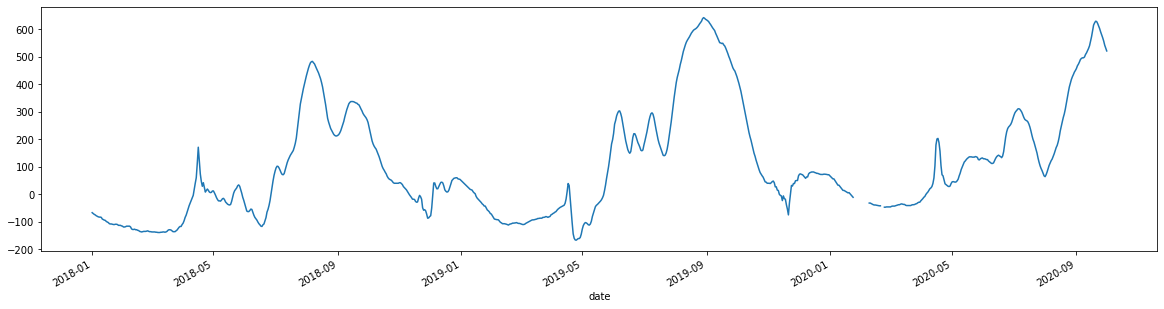

In [752]:
sf = nf[nf['station_id'] == 5012]
sf['stage_max'].plot(figsize=(20,5))

Приведем индексы к такому же виду как в daily и соеденим датасеты 

In [753]:
nf = nf.reset_index()
nf = nf.reindex(['date', 'stage_avg', 'stage_min', 'stage_max', 'temp', 'water_code',
       'station_id'], axis=1)
daily = pd.concat([daily, nf], axis=0)
daily = daily.sort_values(by=['station_id', 'date'])

### Метеоданные 
Загрузка метеоданных, соответстующих целевым гидрологическим постам. 

Используемый датасет `s2m.pkl` - (station_to_meteo) - это таблица в которой номеру гидрологического поста поставлен в соответсвие номер ближайшей метеостанции, а так же указано расстояние до неё. Координаты гидрологических постов и метеостанций взяты из http://asunp.meteo.ru/geoits-rest/services/asunp/geo.json

In [754]:
s2m = pd.read_pickle(path_to_data + 'processed_data/s2m.pkl')
s2m.head()

,meteo_id,dist
station_id,,
5674,4943321,81.846330
5216,4433241,21.467114
6256,5172691,62.347672
5132,4483421,27.216443
5151,4393311,1.111949


Пример таблицы с метеоданными

In [755]:
pd.read_csv(path_to_data + 'meteo/4263131.csv', sep=';').head()

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,...,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,time
0,GAMOV,4263131,NaN,6,254.0,0,5.0,0,NaN,7.0,...,NaN,NaN,5,NaN,6,1.2,0,76.0,0,2013-04-17 21:00:00
1,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,...,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 18:00:00
2,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,...,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 15:00:00
3,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,...,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 12:00:00
4,GAMOV,4263131,NaN,6,233.0,0,7.0,0,NaN,10.0,...,NaN,NaN,5,NaN,6,3.4,0,75.0,0,2013-04-17 09:00:00


In [756]:
# Вспомогательная функция для соединения идентичных датафреймов 
def weary_append(x,y):
    if x is not None:
        if any([a for a in list(x.columns) if a not in y.columns]) or any([a for a in list(y.columns) if a not in x.columns]):
            raise ValueError()
        else:
            return x.append(y)
    else:
        return y

Считываем файлы с метеоданными, соответствующие целевым гидрологическим постам. Номер метеостанции записываем в колонку `meteo_id`, а номер гидрологического поста в `station_id`

In [757]:
meteo = None
for s, m in s2m.loc[station_ids][['meteo_id']].iterrows():
    m = m.values[0]
    df = pd.read_csv(path_to_data + 'meteo/{}.csv'.format(m), sep=';').rename({'station_id': 
                                                                                        'meteo_id'}, axis=1)
    df['datetime'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    df['date'] = df['datetime'].apply(lambda x: x.date())
    df['station_id'] = s
    meteo = weary_append(meteo, df)

Согласно описанию данных (а именно файл Время_85.docx) данные до '1993-1-1' записывались по GMT+3, поэтому переведем их к Гринвичу

In [758]:
meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'] = \
    meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'].apply(lambda x: x - timedelta(hours=3))

Усреднение температурных признаков по (времени суток, дате)

In [759]:
meteo = meteo.set_index('datetime')
meteo[meteo.index.month==3].groupby(meteo[meteo.index.month==3].index.hour)['temperature_air'].mean()

datetime
0    -10.401762
3     -5.039252
6     -2.809799
9     -3.957306
12    -7.727059
15   -10.338852
18   -12.013950
21   -13.245664
Name: temperature_air, dtype: float64

In [760]:
meteo['night'] = (meteo.index.hour > 14) | (meteo.index.hour < 2)
dmeteo = meteo.groupby(['station_id', 'date', 'night'])[['temperature_air', 
                                                    'temperature_ground']].mean().reset_index(level=2)
dmeteo = dmeteo.pivot(columns='night')
ncols = []
for col in dmeteo.columns:
    if col[1]:
        prefix = 'night_'
    else:
        prefix = 'day_'
    ncols.append(prefix + col[0])
dmeteo.columns = ncols

Получили датасет со средней ночной и дневной температурой воздуха и почвы за каждый день.

In [761]:
dmeteo.head()

day_temperature_air  night_temperature_air  \
station_id date                                                     
5004       1985-01-01              -17.900                -24.400   
           1985-01-02              -16.775                -26.250   
           1985-01-03              -18.975                -24.650   
           1985-01-04              -19.150                -26.050   
           1985-01-05              -21.200                -27.675   

                       day_temperature_ground  night_temperature_ground  
station_id date                                                          
5004       1985-01-01                 -19.950                   -27.275  
           1985-01-02                 -19.725                   -29.375  
           1985-01-03                 -19.900                   -26.900  
           1985-01-04                 -19.900                   -28.175  
           1985-01-05                 -21.775                   -28.175

Значения влажности воздуха беру среднее за сутки, а кол-во осадков - максимальное

In [762]:
dmeteo[['humidity', 'precipitation_amount']] = \
meteo.groupby(['station_id', 'date'])[['humidity', 'precipitation_amount']].agg({'humidity': 'mean', 
                                                                                 'precipitation_amount': 'max'})

Реализуем функцию, которая будет аггрегировать метео признаки по заданному количеству дней, заданной функцией и сдвигать на заданное число дней

In [763]:
#!!!дополнительно к бэзлайн решению взял признак температуры воздуха ночь/день за последние 90 дней, тк на вебинаре говорилось,
#что высокие температуры весны в 2013г. оказали влияние на начавшееся позже наводнение
def agg_meteo(df, 
              columns = ['day_temperature_air', 'night_temperature_air', 'day_temperature_ground', 
                         'night_temperature_ground', 'humidity','precipitation_amount', 'day_temperature_air',
                         'night_temperature_air'],
              agg_days = [15, 15, 15, 15, 10, 60, 90, 90],
              agg_funcs = ['mean', 'mean', 'mean', 'mean', 'sum', 'sum', 'mean', 'mean'],
              shift = [10, 10, 10, 10, 10, 10, 10, 10]):
    res = pd.DataFrame(index=df.index)
    names = []
    for c, d, f, s in zip(columns, agg_days, agg_funcs, shift):
        name = '{}_{}_{}'.format(c, d, s)
        res[name] = df[c].rolling(d, min_periods=1).agg(f).shift(s)
        names.append('{}_{}_{}'.format(c, d, s))
    return res.reset_index(), names

In [764]:
agg, meteo_feats = agg_meteo(dmeteo)
agg['date'] = pd.to_datetime(agg['date'])

Присоединяем метеоданные к посуточным замерам уровней

In [765]:
daily = daily.merge(agg, on=['station_id', 'date'], how='left')

In [766]:
daily.shape

(93596, 15)

Создаем "календарные" признаки

In [767]:
daily = daily.set_index('date')
daily['year'] = daily.index.year
daily['month'] = daily.index.month
daily['day'] = daily.index.day
daily['doy'] = daily.index.dayofyear
daily = daily.reset_index()

По графикам можно наблюдать некую годовую сезонность в значениях уровня воды. Поэтому, могут оказаться полезными признаки: значения уровня воды последние годы в предсказываемые даты.

In [768]:
# Вспомогательная функция, прибавляющая года в кол-ву years к дате d
def add_years(d, years):
    try:
        return d.replace(year = d.year + years)
    except ValueError:
        return d + (datetime(d.year + years, 1, 1) - datetime(d.year, 1, 1))

In [769]:
# Цикл по количеству рассматриваемых лет
# !!!Увеличил количество лет до 30, тк упоминалось, что присутствует некая сезонность в резких наводениях на Амуре 
#не превышающая данный период
past = []
for y in range(1, 31):
    daily['ndate'] = daily['date'].apply(lambda x: add_years(x, y))
    hf = daily[['ndate', 'station_id', 'stage_max']].rename({'ndate': 'date', 'stage_max': 
                                                             'past_{}'.format(y)}, axis=1)
    
#     Удаление дубликатов, появляющихся из-за 29 февраля
    hf = hf.set_index(['station_id', 'date']) 
    hf = hf[~hf.index.duplicated(keep='first')]
    hf = hf.reset_index()
    
    daily = daily.merge(hf, on=['station_id', 'date'], how='left').drop('ndate', axis=1)
#     Цикл по датам целевого периода
    for i in range(predict_ndays+1):
        daily['past_{}_{}'.format(y, i)] = daily['past_{}'.format(y)].shift(-i)
        past.append('past_{}_{}'.format(y, i))
    daily.drop('past_{}'.format(y), axis=1, inplace=True)

Осталось добавить признаки временного ряда, то есть значения таргета за ndays предыдущих дней. Но, так как в исходных датасетах встречаются пропущенные даты, их надо сначала заполнить NaN'ми. Для этого воспользуемся методом .date_range и .reindex

In [770]:
daily = daily.set_index(['station_id', 'date'])
new_index = pd.MultiIndex.from_product([daily.index.get_level_values(0).unique(), 
                                        pd.date_range('1984-1-1', '2020-10-01')])
daily = daily.reindex(new_index)

Создание признаков временного ряда

In [771]:
ndays = 20

In [772]:
#!!! Так как в дальнейшем использую библиотеку heamy, чтобы избежать обучение на данных из будущего, 
#беру данные об уровнях реки от 11 дня
daily['target'] = daily['stage_max']
ts = []
for i in range(ndays, 10, -1):
    daily['ts_{}'.format(i)] = daily.groupby('station_id')['stage_max'].shift(i)
    ts.append('ts_{}'.format(i))

Выкидываем строки в которых таргет NaN

In [773]:
daily = daily[daily['target'].notna()]

In [774]:
daily = daily.fillna(0)

In [775]:
#!!! получаем признаки
daily.columns

Index(['stage_avg', 'stage_min', 'stage_max', 'temp', 'water_code',
       'day_temperature_air_15_10', 'night_temperature_air_15_10',
       'day_temperature_ground_15_10', 'night_temperature_ground_15_10',
       'humidity_10_10',
       ...
       'ts_20', 'ts_19', 'ts_18', 'ts_17', 'ts_16', 'ts_15', 'ts_14', 'ts_13',
       'ts_12', 'ts_11'],
      dtype='object', length=358)

## Обучение

Для кросс-валидации использум деление выборки на __train__: до *f_day* i-го года; __test__: _predictperiod_ i-го года, где i пробегает 5 последних лет, имеющихся в тренировочной выборке.

In [776]:
# Генератор индексов для кросс-валидации
def train_test_fold(df, f_day, l_day):
    for year in [f_day.year - 5 + i for i in range(5)]:
        f = '{}-{}'.format(year, datetime.strftime(f_day, '%m-%d'))
        l = '{}-{}'.format(year, datetime.strftime(l_day, '%m-%d'))
        yield df.index[df.index < f], df.index[(df.index>=f)&(df.index<l)]

Реализация функции пошагового предсказания.
На вход подается:
- `model` - обученная модель
- `ts_data` - значения таргета за последние _ndays_ тренировочной выборки
- `test_data` - дополнительные признаки, в тестовый период (признаки не должны зависеть от значений, которые могут быть получены только в тестовый период. Поэтому, например, все погодные признаки сдвинуты на _predict_ndays_ вперед)
- `features` - список названий доп. признаков
- `n` - количество дней, на которые строится предказание

In [777]:
#!!! Так как использую библиотеку heamy, то привожу ей в соответствие step_predict из бэзлайн решения
def steps_predict(model, ts_data, test_data, features, n):
    isfeat = len(features) > 0
    test_features = test_data[features].values
    if isfeat:
        data = np.r_[test_features[0], ts_data].reshape(1,-1)
    else:
        data = ts_data.reshape(1,-1)
    predict = []
    #predict.append(model.predict(data)[0])
    predict.append(model.predict()[0])

    for i in range(1, n):
        ts_data = np.r_[ts_data[1:], predict[i-1]]
        if isfeat:
            data = np.r_[test_features[i], ts_data].reshape(1,-1)
        else:
            data = ts_data.reshape(1,-1)
        #predict.append(model.predict(data)[0])
        predict.append(model.predict()[i])
    return np.array(predict)

In [778]:
def metrics(true, pred, station_id, printit=False):
    mae = np.mean(np.abs(pred - true))   
    if printit:
        print("MAE: {}".format(mae))
    return mae

In [779]:
def plot_predict(true, pred, station_id=None):
    plt.figure(figsize=(20, 5))
    plt.plot(true)
    plt.plot(pred)
    leg = ['true values', 'predict values']
    
    plt.legend(leg)
    if station_id is not None:
        plt.title(station_id)
    plt.show()

Посмотрим на степень влияния дополнительных признаков на результат работы модели. Для этого воспользуемся библиотекой `shap` https://shap.readthedocs.io/en/latest/index.html 

Обучение LGBM с дефолтными параметрами и всеми доп. признакими.

In [780]:
all_features = meteo_feats + ['year', 'month', 'doy'] + past
station_id = 5012
features = all_features

sf = daily.loc[station_id]
model_lgb = lgb.LGBMRegressor(random_state=33)
X_train = sf.loc[sf.index < f_day, features]
y_train = sf.loc[sf.index < f_day, 'target']
X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
model_lgb.fit(X_train, y_train)

LGBMRegressor(random_state=33)

In [781]:
X_importance = X_train
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_importance)

Построения графика важности дополнительных признаков.

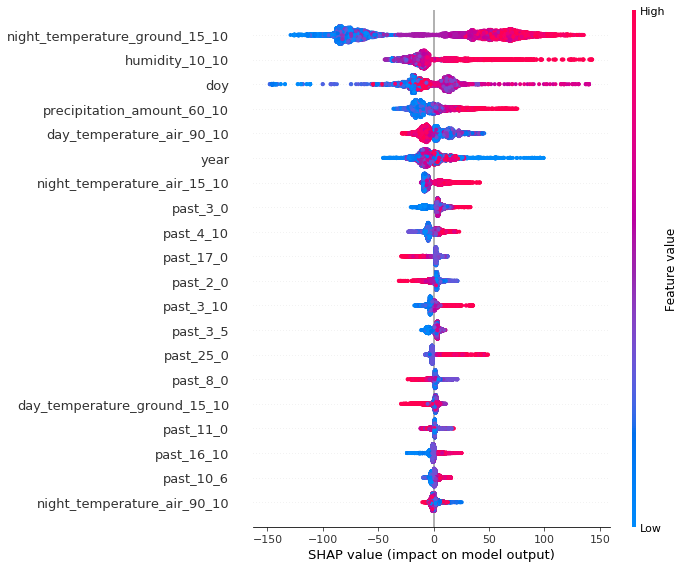

In [782]:
shap.summary_plot(shap_values, X_importance)
#!!! в дополнении к бэзлайн анализу хочу отметить положительный вклад признаков:
# night_temperature_ground_15_10, night_temperature_air_15_10 - средняя температура ночью земли и воздуха за 15 дней,
# 10 дней назад
# несмотря на низкую важность параметров day_temperature_air_90_10, night_temperature_air_90_10 - средняя температура воздуха
# днем и ночью за 90 дней, 10 дней назад, считаю их влияние на паводки существенным, тк наличие весной продолжительных 
# ночных заморозков, сопровождающееся дневными плюсовыми температурами, способствует снижению уровня воды.

Из графика видно, что метеопризнаки довольно сильно влияют на целевое значение. Например, 
как и ожидалось, признак `precipitation_amount_60_10` - накопленные осадки за 60 дней, 10 дней назад при больших значениях дает положительный вклад в целевое значение, а при малых - отрицательный. Тот же эффект виден для `humidity_10_10` - накопленная влажность воздуха за 10 дней, 10 дней назад.

### Результаты
В следующей ячейки собирается таблица с результатами предсказаний `sample_submission`. 

Построены графики с предсказанными и настоящими значениями и выведено значение метрики для каждого гидрологического поста.

[18:01:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 109.0043855	total: 77.4ms	remaining: 7.66s
1:	learn: 91.5723282	total: 140ms	remaining: 6.88s
2:	learn: 81.3882370	total: 201ms	remaining: 6.51s
3:	learn: 75.2240842	total: 263ms	remaining: 6.31s
4:	learn: 70.4263047	total: 325ms	remaining: 6.17s
5:	learn: 67.3151870	total: 390ms	remaining: 6.11s
6:	learn: 65.2665579	total: 448ms	remaining: 5.95s
7:	learn: 63.8535346	total: 509ms	remaining: 5.85s
8:	learn: 62.6887452	total: 568ms	remaining: 5.75s
9:	learn: 61.4726886	total: 629ms	remaining: 5.66s
10:	learn: 59.9259731	total: 690ms	remaining: 5.58s
11:	learn: 58.7358074	total: 750ms	remaining: 5.5s
12:	learn: 57.7015558	total: 811ms	remaining: 5.43s
13:	learn: 57.1369898	total: 872ms	remaining: 5.36s
14:	learn: 56.4170129	total: 945ms	remaining: 5.36s
15:	learn: 55.8219553	total: 1s	remaining: 5.27s
16:	learn: 55.1093031	total: 1.06s	remaining: 5.18s
17:	learn: 5

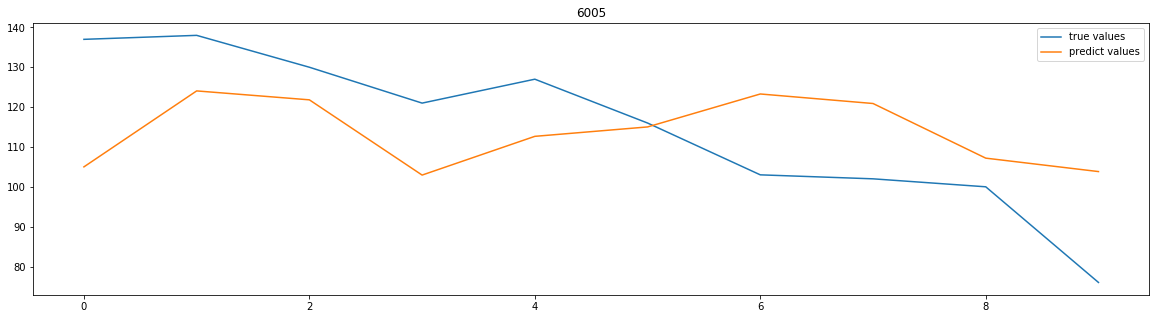

[18:02:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 105.1522958	total: 61.4ms	remaining: 6.08s
1:	learn: 87.2767310	total: 114ms	remaining: 5.58s
2:	learn: 76.8496644	total: 166ms	remaining: 5.36s
3:	learn: 71.4561873	total: 218ms	remaining: 5.24s
4:	learn: 67.6585078	total: 269ms	remaining: 5.12s
5:	learn: 65.0043521	total: 319ms	remaining: 5s
6:	learn: 63.2096520	total: 369ms	remaining: 4.9s
7:	learn: 61.5590705	total: 420ms	remaining: 4.83s
8:	learn: 60.3706668	total: 471ms	remaining: 4.76s
9:	learn: 58.8595732	total: 522ms	remaining: 4.7s
10:	learn: 58.0456100	total: 575ms	remaining: 4.65s
11:	learn: 57.1239597	total: 625ms	remaining: 4.58s
12:	learn: 56.3118198	total: 677ms	remaining: 4.53s
13:	learn: 55.4710948	total: 727ms	remaining: 4.47s
14:	learn: 54.7303397	total: 778ms	remaining: 4.41s
15:	learn: 53.9829866	total: 827ms	remaining: 4.34s
16:	learn: 53.2978614	total: 880ms	remaining: 4.29s
17:	learn: 52

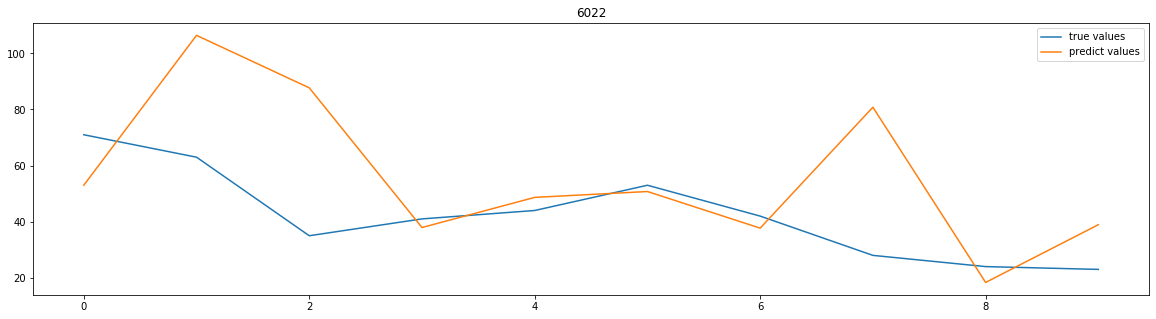

[18:03:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 128.5567234	total: 70.3ms	remaining: 6.96s
1:	learn: 108.0776834	total: 128ms	remaining: 6.28s
2:	learn: 96.2727911	total: 184ms	remaining: 5.95s
3:	learn: 89.0453491	total: 240ms	remaining: 5.75s
4:	learn: 84.4251741	total: 296ms	remaining: 5.63s
5:	learn: 80.9287186	total: 350ms	remaining: 5.48s
6:	learn: 78.9701379	total: 404ms	remaining: 5.37s
7:	learn: 76.9784294	total: 458ms	remaining: 5.27s
8:	learn: 75.4256255	total: 512ms	remaining: 5.18s
9:	learn: 74.1032533	total: 568ms	remaining: 5.11s
10:	learn: 72.5594119	total: 622ms	remaining: 5.04s
11:	learn: 71.6069671	total: 680ms	remaining: 4.99s
12:	learn: 70.2265936	total: 736ms	remaining: 4.92s
13:	learn: 69.1213669	total: 792ms	remaining: 4.86s
14:	learn: 68.4571528	total: 844ms	remaining: 4.78s
15:	learn: 67.7477681	total: 912ms	remaining: 4.79s
16:	learn: 67.0186777	total: 965ms	remaining: 4.71s
17:	lea

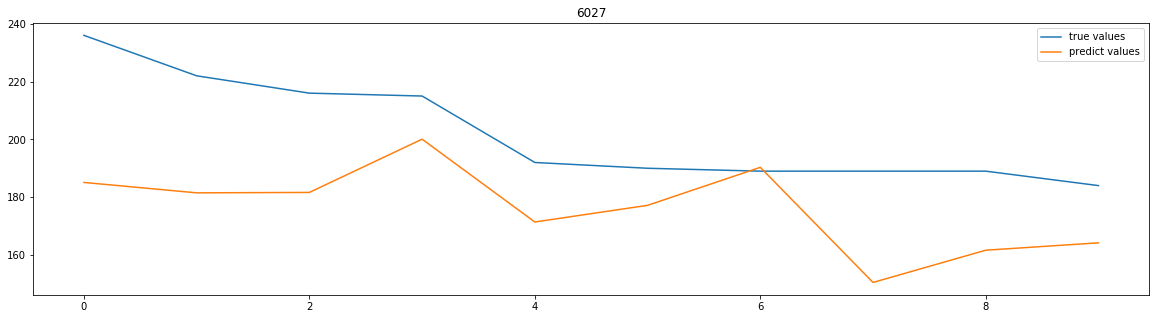

[18:04:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 142.5778006	total: 63.2ms	remaining: 6.25s
1:	learn: 115.2688661	total: 116ms	remaining: 5.67s
2:	learn: 97.7369531	total: 169ms	remaining: 5.46s
3:	learn: 87.5940190	total: 222ms	remaining: 5.32s
4:	learn: 81.7934803	total: 277ms	remaining: 5.27s
5:	learn: 77.8671095	total: 328ms	remaining: 5.13s
6:	learn: 74.8338216	total: 383ms	remaining: 5.09s
7:	learn: 71.8718242	total: 437ms	remaining: 5.02s
8:	learn: 70.3776505	total: 489ms	remaining: 4.95s
9:	learn: 69.1393098	total: 539ms	remaining: 4.85s
10:	learn: 67.8348836	total: 597ms	remaining: 4.83s
11:	learn: 66.5391037	total: 647ms	remaining: 4.75s
12:	learn: 65.6614201	total: 697ms	remaining: 4.67s
13:	learn: 64.5122168	total: 750ms	remaining: 4.61s
14:	learn: 63.2682804	total: 804ms	remaining: 4.55s
15:	learn: 62.6604715	total: 855ms	remaining: 4.49s
16:	learn: 61.9776921	total: 927ms	remaining: 4.53s
17:	lea

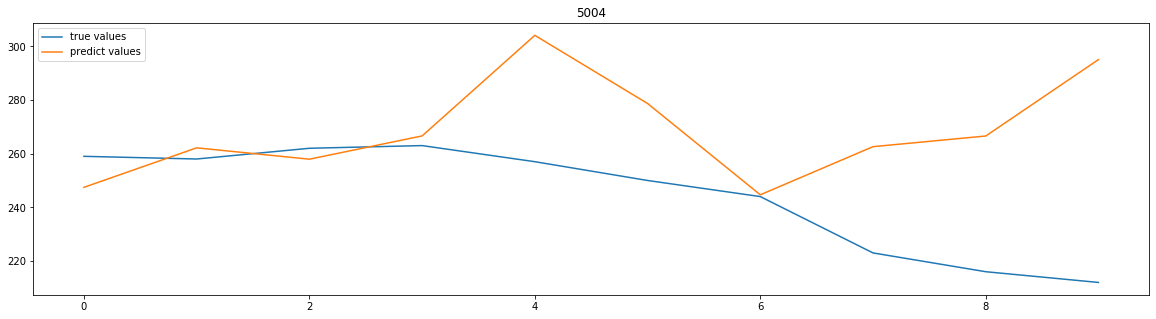

[18:05:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 130.9151305	total: 60ms	remaining: 5.93s
1:	learn: 103.4859213	total: 114ms	remaining: 5.58s
2:	learn: 87.8894445	total: 166ms	remaining: 5.37s
3:	learn: 77.0498246	total: 217ms	remaining: 5.21s
4:	learn: 70.1989460	total: 272ms	remaining: 5.16s
5:	learn: 66.0554675	total: 324ms	remaining: 5.07s
6:	learn: 62.8439148	total: 374ms	remaining: 4.97s
7:	learn: 60.5972541	total: 424ms	remaining: 4.87s
8:	learn: 58.8873947	total: 477ms	remaining: 4.82s
9:	learn: 57.5797740	total: 526ms	remaining: 4.73s
10:	learn: 56.2322632	total: 578ms	remaining: 4.68s
11:	learn: 55.3427743	total: 628ms	remaining: 4.61s
12:	learn: 54.6293801	total: 678ms	remaining: 4.54s
13:	learn: 53.2774000	total: 731ms	remaining: 4.49s
14:	learn: 52.3446415	total: 780ms	remaining: 4.42s
15:	learn: 51.8967632	total: 830ms	remaining: 4.36s
16:	learn: 51.1251208	total: 881ms	remaining: 4.3s
17:	learn:

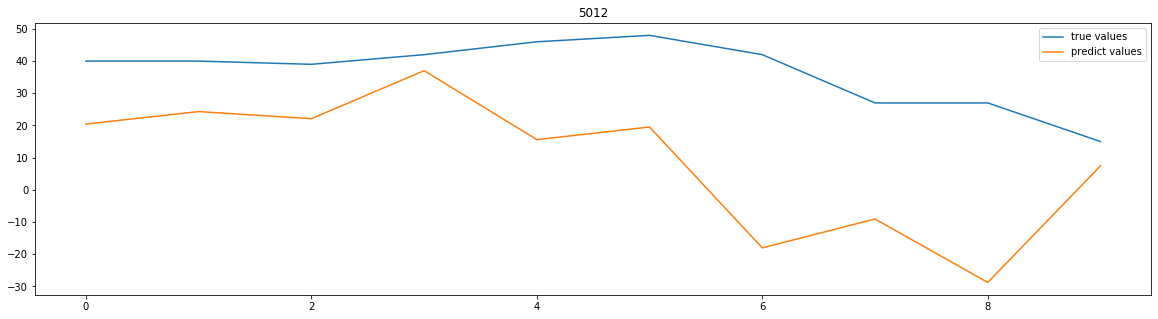

[18:06:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 146.8069618	total: 61.1ms	remaining: 6.05s
1:	learn: 114.7277223	total: 116ms	remaining: 5.71s
2:	learn: 95.1890070	total: 168ms	remaining: 5.43s
3:	learn: 82.6962103	total: 221ms	remaining: 5.3s
4:	learn: 75.0943787	total: 275ms	remaining: 5.22s
5:	learn: 69.6690976	total: 327ms	remaining: 5.12s
6:	learn: 65.4643421	total: 381ms	remaining: 5.07s
7:	learn: 62.5582638	total: 435ms	remaining: 5s
8:	learn: 61.3604622	total: 486ms	remaining: 4.92s
9:	learn: 59.7744872	total: 538ms	remaining: 4.84s
10:	learn: 58.5021189	total: 590ms	remaining: 4.77s
11:	learn: 57.0813118	total: 644ms	remaining: 4.72s
12:	learn: 56.5205917	total: 695ms	remaining: 4.65s
13:	learn: 55.7481499	total: 747ms	remaining: 4.59s
14:	learn: 54.9277015	total: 799ms	remaining: 4.53s
15:	learn: 53.8607954	total: 858ms	remaining: 4.5s
16:	learn: 53.0703727	total: 921ms	remaining: 4.5s
17:	learn: 52

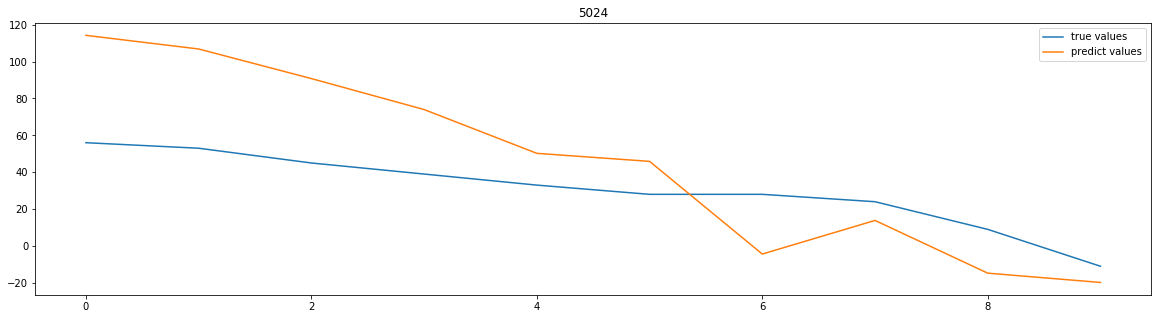

[18:07:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 34.1423742	total: 58.7ms	remaining: 5.81s
1:	learn: 27.8274044	total: 109ms	remaining: 5.32s
2:	learn: 23.7866396	total: 159ms	remaining: 5.15s
3:	learn: 21.3373522	total: 208ms	remaining: 4.99s
4:	learn: 20.2274540	total: 261ms	remaining: 4.95s
5:	learn: 19.2326002	total: 311ms	remaining: 4.88s
6:	learn: 18.6160335	total: 362ms	remaining: 4.8s
7:	learn: 18.2719152	total: 412ms	remaining: 4.73s
8:	learn: 17.9179652	total: 459ms	remaining: 4.64s
9:	learn: 17.6947065	total: 508ms	remaining: 4.57s
10:	learn: 17.4273621	total: 557ms	remaining: 4.51s
11:	learn: 17.2463976	total: 606ms	remaining: 4.45s
12:	learn: 17.0807820	total: 656ms	remaining: 4.39s
13:	learn: 16.9118228	total: 705ms	remaining: 4.33s
14:	learn: 16.7957254	total: 751ms	remaining: 4.25s
15:	learn: 16.6524317	total: 797ms	remaining: 4.18s
16:	learn: 16.4819399	total: 844ms	remaining: 4.12s
17:	learn:

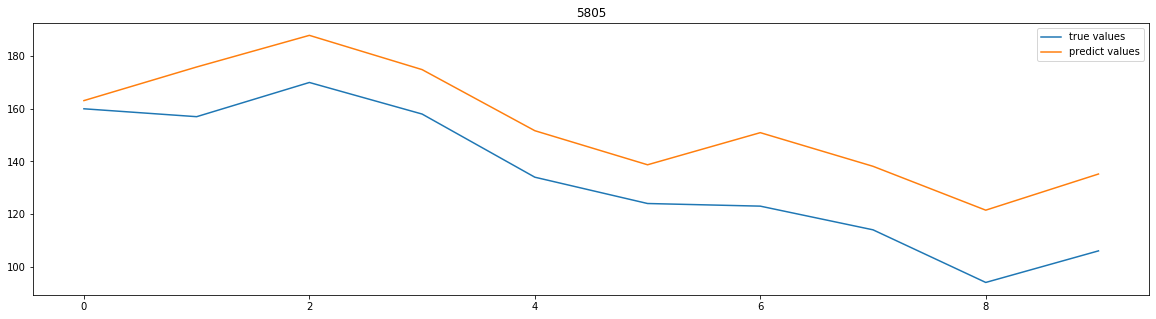

In [783]:
from fbprophet import Prophet
from catboost import CatBoostRegressor
import xgboost
from sklearn.ensemble import ExtraTreesRegressor
from heamy.dataset import Dataset
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline

model_params = ['6005','6022','6027','5004','5012','5024','5805']

sample_submission = pd.DataFrame(index=pd.date_range(f_day, l_day - timedelta(1)))
lgbm_metrics = {}
for key in model_params:
    all_features = meteo_feats + ['year', 'month', 'doy'] + past + ts
    features = all_features
    station_id = int(key)
    sf = daily.loc[int(key)]
    
    #создаем и обучаем Prophet для использования полученных результатов (yhat,trend,daily) в качестве дополнительных признаков
    m = Prophet(daily_seasonality=True, yearly_seasonality=True, seasonality_prior_scale=10, seasonality_mode='additive')
    
    y_train = sf.loc[sf.index < f_day, 'target']
    y_train = y_train.to_frame()
    y_train.reset_index(inplace=True)
    y_train = y_train.rename(columns={'index': 'ds','target': 'y'})
    m.fit(y_train)
    future = m.make_future_dataframe(periods=10)
    predict_forecast = m.predict(future)
    predict_forecast = predict_forecast.set_index('ds')
    predict_forecast_trend = predict_forecast[['yhat','trend','daily']]
    
    X_train = sf.loc[sf.index < f_day, features]
    y_train = sf.loc[sf.index < f_day, 'target']
    
    X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
    y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
    
    trend = predict_forecast_trend.tail(10)
    X_test = X_test.join(trend)
    #добавим параметр прироста/снижения за последние 10 дней
    cols = ['ts_20','ts_11']
    X_test = X_test.eval("ts_raise = {}".format("/".join(cols)))
    
    predict_forecast_trend = predict_forecast_trend.iloc[:-10]
    trend = predict_forecast_trend
    X_train = X_train.join(trend)
    #добавим параметр прироста/снижения за последние 10 дней
    cols = ['ts_20','ts_11']
    X_train = X_train.eval("ts_raise = {}".format("/".join(cols)))
    features = all_features + ['yhat','trend','daily']

    # создаем датасет и обучаем на CatBoostRegressor и XGBRegressor, обученные модели используем для создания нового датасета
    # используя блэндинг
    dataset = Dataset(X_train,y_train, X_test)
    
    model_cbr = Regressor(dataset=dataset, estimator=CatBoostRegressor,
                          parameters={'n_estimators': 100,'learning_rate': 0.35,'random_state': 33, 
                                      'approx_on_full_history': False},name='cbr', use_cache=False)
    model_xgbr = Regressor(dataset=dataset, estimator=xgboost.XGBRegressor,
                          parameters={'n_estimators': 100,'learning_rate': 0.1,'random_state': 33,  
                                      'max_depth': 3, 'n_jobs': -1}, name='xgbr', use_cache=False)
    pipeline = ModelsPipeline(model_xgbr,model_cbr)
    stack_ds = pipeline.blend(proportion=0.2)
    #финальная модель ExtraTreesRegressor
    model_stacker = Regressor(dataset=stack_ds, estimator=ExtraTreesRegressor, 
                              parameters={'n_estimators': 100,'criterion': 'mse','max_features': 'sqrt', 
                                          'random_state': 33,'n_jobs': -1},name='etr', use_cache=False)
    
    ts_data = y_train.values[-ndays:]
    predict = steps_predict(model_stacker, ts_data, X_test, features, predict_ndays)
    sample_submission[key] = predict # запись результата в таблицу
    mae = metrics(y_test.values, predict, station_id)
    lgbm_metrics[station_id] = [mae]
    print(station_id, ' MAE: ', mae, '  MEDIAN: ', np.median(predict))
    plot_predict(y_test.values, predict, station_id)

Сформируем файл с результатом

In [784]:
sample_submission

,6005,6022,6027,5004,5012,5024,5805
2019-11-01,105.00,53.02,185.090,247.44,20.44,114.21,163.11
2019-11-02,124.06,106.43,181.490,262.16,24.31,106.82,175.89
2019-11-03,121.82,87.72,181.640,257.93,22.11,90.77,187.91
2019-11-04,102.94,37.93,200.066,266.60,37.02,73.98,174.89
2019-11-05,112.66,48.67,171.406,304.08,15.60,50.23,151.67
2019-11-06,115.02,50.76,177.166,278.69,19.51,45.88,138.72
2019-11-07,123.29,37.71,190.316,244.66,-18.05,-4.38,150.93
2019-11-08,120.90,80.81,150.480,262.60,-9.07,13.85,138.14
2019-11-09,107.19,18.35,161.640,266.57,-28.79,-14.75,121.47
2019-11-10,103.82,38.94,164.190,295.05,7.43,-19.78,135.21


Сохранение результата

In [785]:
sample_submission.to_csv('sample_submission.csv')